# spectroscopic selection degrader to emulate HSC training samples

The spectroscopic selection degrader can be used to model the spectroscopic success rates in training sets based on real data.  Given a 2-dimensional grid of spec-z success ratio as a function of two variables (often magnitude or color), the degrader will draw the appropriate fraction of samples from the input data and return a sample with incompleteness modeled.  An additional redshift cut can also be applied, where all redshifts above the cutoff are also removed from the sample.

In this quick notebook we'll create a grid of mock galaxies on the same grid on which the HyperSuprimeCam Survey (HSC) spectroscopic success has been parameterized by Irene Moskowitz (and available in `RAIL/examples/creation/data`), and plot the success rate to visualize the spectroscopic success rate for HSC.

In [1]:
import rail
import os
import matplotlib.pyplot as plt
import numpy as np
import tables_io
import pandas as pd
#from rail.core.data import TableHandle
from rail.core.stage import RailStage
%matplotlib inline 

/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

Let's make fake data matching the grid used by HSC.  The 2D grid of spec-z success in this case is parameterized in terms of `g-z` color vs `i-band` magnitude, with `g-z` between `[-2, 6]` and `i-band` magnitude spanning `[13, 26]`.  Let's generate 2000000 objects with random `i` magnitude and `g-z` color and redshift. The magnitudes in other biands are set to 20.0.

In [3]:
i = np.random.uniform(low=13.0325, high=25.9675, size=(2000000,))
gz = np.random.uniform(low=-1.98, high=5.98, size=(2000000,))
u = np.full_like(i, 20.0, dtype=np.double)
g = np.full_like(i, 20.0, dtype=np.double)
r = np.full_like(i, 20.0, dtype=np.double)
y = np.full_like(i, 20.0, dtype=np.double)
z = g - gz
redshift = np.round(np.random.uniform(size=len(i))*2.5, 2)

In [4]:
mockdict = {}
for label, item in zip(['mag_u_lsst', 'mag_g_lsst','mag_r_lsst','mag_i_lsst', 'mag_z_lsst','mag_y_lsst', 'redshift'], [u,g,r,i,z,y, redshift]):
    mockdict[f'{label}'] = item#np.repeat(item, 100).flatten()

In [5]:
mockdict

{'mag_u_lsst': array([20., 20., 20., ..., 20., 20., 20.]),
 'mag_g_lsst': array([20., 20., 20., ..., 20., 20., 20.]),
 'mag_r_lsst': array([20., 20., 20., ..., 20., 20., 20.]),
 'mag_i_lsst': array([18.89006596, 13.09033333, 17.10419527, ..., 25.59531988,
        15.42217621, 13.76680569]),
 'mag_z_lsst': array([17.25610648, 14.79555021, 16.84222939, ..., 21.40892991,
        21.21480967, 15.16217547]),
 'mag_y_lsst': array([20., 20., 20., ..., 20., 20., 20.]),
 'redshift': array([0.75, 0.46, 0.16, ..., 0.29, 1.85, 0.33])}

In [6]:
df = pd.DataFrame(mockdict)

In [7]:
df.head()

,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,redshift
0,20.0,20.0,20.0,18.890066,17.256106,20.0,0.75
1,20.0,20.0,20.0,13.090333,14.795550,20.0,0.46
2,20.0,20.0,20.0,17.104195,16.842229,20.0,0.16
3,20.0,20.0,20.0,20.928731,14.556936,20.0,0.21
4,20.0,20.0,20.0,25.888511,21.892444,20.0,2.00


Now, let's import the spectroscopic_selections degrader and set up the config dict parameters.  We will set a redshift cut of 5.1 so as to not cut any of our mock galaxies, if you would want a redshift cut, you would simply change this parameter as desired.<br>

In [8]:
import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_May5/RAIL/rail/creation/degradation')
import spectroscopic_selections
from importlib import reload
from spectroscopic_selections import SpecSelection_HSC

In [9]:
hsc_selecter = SpecSelection_HSC.make_stage(downsample=False)

Let's run the code and see how long it takes:

In [10]:
%%time
trim_data = hsc_selecter(df)

Inserting handle into data store.  input: None, specselection_HSC
Inserting handle into data store.  output: inprogress_output.pq, specselection_HSC
CPU times: user 2.79 s, sys: 30.9 ms, total: 2.82 s
Wall time: 2.74 s


This took 2.2s on our server.

In [11]:
trim_data.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315433 entries, 0 to 1999995
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mag_u_lsst  315433 non-null  float64
 1   mag_g_lsst  315433 non-null  float64
 2   mag_r_lsst  315433 non-null  float64
 3   mag_i_lsst  315433 non-null  float64
 4   mag_z_lsst  315433 non-null  float64
 5   mag_y_lsst  315433 non-null  float64
 6   redshift    315433 non-null  float64
dtypes: float64(7)
memory usage: 19.3 MB


And we see that we've kept ~315433 out of the 2,000,000 galaxies in the initial sample, so about 15% of the initial sample.  To visualize our cuts, let's read in the success ratios file and plot our sample overlaid with an alpha of 0.01, that way the strength of the black dot will give a visual indication of how many galaxies in each cell we've kept.

In [12]:
bgr, bi = np.meshgrid(np.linspace(-2, 6, 201), np.linspace(13, 26, 201))

In [13]:
bratios = np.loadtxt('../../examples/creation/data/success_rate_data/hsc_success.txt')

np.savetxt('./data/hsc_gi_binedge.txt',np.linspace(-2, 6, 201))
np.savetxt('./data/hsc_i_binedge.txt',np.linspace(13, 26, 201))
np.savetxt('./data/hsc_success.txt',bratios)

In [14]:
trim_data.data

,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,redshift
0,20.0,20.0,20.0,18.890066,17.256106,20.0,0.75
9,20.0,20.0,20.0,20.273017,19.390795,20.0,0.78
16,20.0,20.0,20.0,15.014015,18.671860,20.0,1.87
18,20.0,20.0,20.0,19.172797,15.885560,20.0,1.14
29,20.0,20.0,20.0,17.401027,19.130449,20.0,0.69
...,...,...,...,...,...,...,...
1999977,20.0,20.0,20.0,18.726089,17.469374,20.0,2.43
1999980,20.0,20.0,20.0,18.425321,16.921940,20.0,1.54
1999985,20.0,20.0,20.0,22.947376,14.225841,20.0,1.56
1999987,20.0,20.0,20.0,20.053590,19.864208,20.0,1.68


Text(0, 0.5, 'g-z')

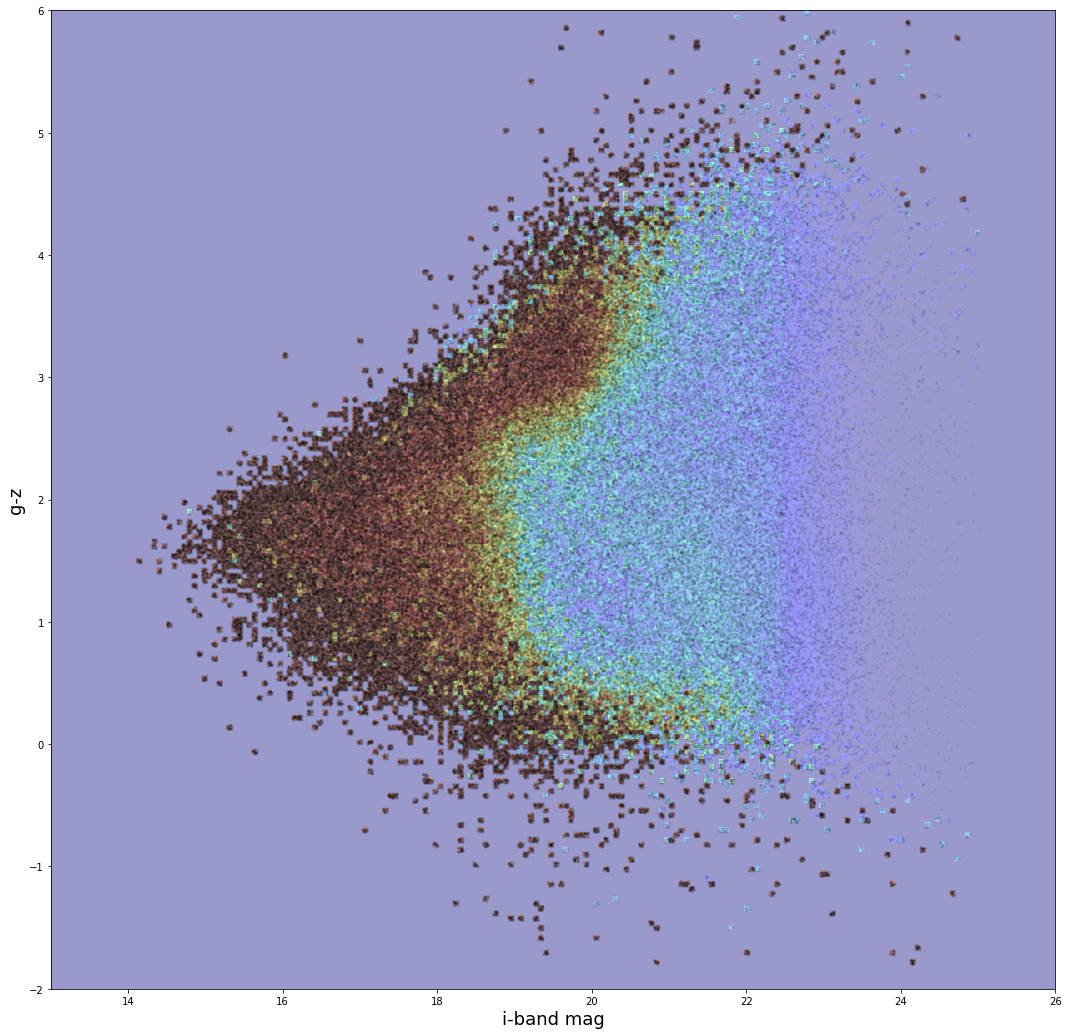

In [15]:
plt.figure(figsize=(18,18))
plt.pcolormesh(bi, bgr, bratios.T, cmap='jet', vmin=0, vmax=1,alpha=0.4)
plt.scatter(trim_data.data['mag_i_lsst'], trim_data.data['mag_g_lsst']-trim_data.data['mag_z_lsst'], s=3, c='k',alpha =.05)
plt.xlabel("i-band mag", fontsize=18)
plt.ylabel("g-z", fontsize=18)

The colormap shows the HSC ratios and the strenth of the black dots shows how many galaxies were actually kept. We see perfect agreement between our predicted ratios and the actual number of galaxies kept, the degrader is functioning properly, and we see a nice visual representation of the resulting spectroscopic sample incompleteness.